# Using LLM for anomalies detections

## Vocabulary

In [4]:
from collections import OrderedDict
import numpy as np


class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


class Vocabulary:
    def __init__(self, adap_thres=10000, target_column_name="Is Fraud?"):
        self.unk_token = "[UNK]"
        self.sep_token = "[SEP]"
        self.pad_token = "[PAD]"
        self.cls_token = "[CLS]"
        self.mask_token = "[MASK]"
        self.bos_token = "[BOS]"
        self.eos_token = "[EOS]"

        self.adap_thres = adap_thres
        self.adap_sm_cols = set()

        self.target_column_name = target_column_name
        self.special_field_tag = "SPECIAL"

        self.special_tokens = [self.unk_token, self.sep_token, self.pad_token,
                               self.cls_token, self.mask_token, self.bos_token, self.eos_token]

        self.token2id = OrderedDict()
        self.id2token = OrderedDict()
        self.field_keys = OrderedDict()
        self.token2id[self.special_field_tag] = OrderedDict()

        for token in self.special_tokens:
            global_id = len(self.id2token)
            local_id = len(self.token2id[self.special_field_tag])

            self.token2id[self.special_field_tag][token] = [global_id, local_id]
            self.id2token[global_id] = [token, self.special_field_tag, local_id]

    def set_id(self, token, field_name, return_local=False):
        global_id, local_id = None, None

        if token not in self.token2id[field_name]:
            global_id = len(self.id2token)
            local_id = len(self.token2id[field_name])

            self.token2id[field_name][token] = [global_id, local_id]
            self.id2token[global_id] = [token, field_name, local_id]
        else:
            global_id, local_id = self.token2id[field_name][token]

        if return_local:
            return local_id

        return global_id

    def get_id(self, token, field_name="", special_token=False, return_local=False):
        global_id, local_id = None, None
        if special_token:
            field_name = self.special_field_tag

        if token in self.token2id[field_name]:
            global_id, local_id = self.token2id[field_name][token]

        else:
            raise Exception(f"token {token} not found in field: {field_name}")

        if return_local:
            return local_id

        return global_id

    def set_field_keys(self, keys):

        for key in keys:
            self.token2id[key] = OrderedDict()
            self.field_keys[key] = None

        self.field_keys[self.special_field_tag] = None

    def get_field_ids(self, field_name, return_local=False):
        if field_name in self.token2id:
            ids = self.token2id[field_name]
        else:
            raise Exception(f"field name {field_name} is invalid.")

        selected_idx = 0
        if return_local:
            selected_idx = 1
        return [ids[idx][selected_idx] for idx in ids]

    def get_from_global_ids(self, global_ids, what_to_get='local_ids'):
        device = global_ids.device

        def map_global_ids_to_local_ids(gid):
            return self.id2token[gid][2] if gid != -100 else -100

        def map_global_ids_to_tokens(gid):
            return f'{self.id2token[gid][1]}_{self.id2token[gid][0]}' if gid != -100 else '-'

        if what_to_get == 'local_ids':
            return global_ids.cpu().apply_(map_global_ids_to_local_ids).to(device)
        elif what_to_get == 'tokens':
            vectorized_token_map = np.vectorize(map_global_ids_to_tokens)
            new_array_for_tokens = global_ids.detach().clone().cpu().numpy()
            return vectorized_token_map(new_array_for_tokens)
        else:
            raise ValueError("upsss")

    def get_field_keys(self, remove_target=True, ignore_special=False):
        keys = list(self.field_keys.keys())

        if remove_target and self.target_column_name in keys:
            keys.remove(self.target_column_name)
        if ignore_special:
            keys.remove(self.special_field_tag)
        return keys

    def get_special_tokens(self):
        special_tokens_map = {}
        keys = ["unk_token", "sep_token", "pad_token", "cls_token", "mask_token", "bos_token", "eos_token"]
        for key, token in zip(keys, self.special_tokens):
            token = "%s_%s" % (self.special_field_tag, token)
            special_tokens_map[key] = token

        return AttrDict(special_tokens_map)

    def __len__(self):
        return len(self.id2token)

    def __str__(self):
        str_ = 'vocab: [{} tokens]  [field_keys={}]'.format(len(self), self.field_keys)
        return str_

In [5]:
import os
from os import path
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import torch
from torch.utils.data.dataset import Dataset

# Utility to divide a list into chunks of size `n`
def divide_chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

# Custom PyTorch Dataset for handling transaction data
class TransactionDataset(Dataset):
    def __init__(self,
                 user_ids=None,
                 seq_len=5,
                 num_bins=15,
                 root="./",
                 fname="/kaggle/input/transactions/card_transaction.v1.csv",
                 vocab_dir="checkpoints",
                 nrows=None,
                 flatten=True,
                 stride=3,
                 adap_thres=10 ** 8,
                 return_labels=False,
                 skip_user=False,
                 task_type="masking_learning"):
        # Initialize dataset parameters and configurations
        self.root = root
        self.fname = fname
        self.nrows = nrows
        self.user_ids = user_ids
        self.return_labels = return_labels
        self.skip_user = skip_user
        self.trans_stride = stride
        self.flatten = flatten
        self.vocab = Vocabulary(adap_thres)
        self.seq_len = seq_len
        self.encoder_fit = {} 
        self.trans_table = None
        self.data = [] 
        self.labels = []
        self.window_label = []
        self.ncols = None
        self.num_bins = num_bins
        self.task_type = task_type

        # Load and preprocess the data
        self.encode_data()
        # Initialize vocabulary with transaction field keys
        self.init_vocab()
        # Prepare the samples for training/testing
        self.prepare_samples()

    def __getitem__(self, index):
        # Return a single sample, optionally flattened
        return_data = torch.tensor(self.data[index], dtype=torch.long)

        if self.task_type == "classification":
            return{
                "input_ids": torch.tensor(self.data[index], dtype=torch.long),
                "label": self.window_label[index]
            }

        if self.return_labels:
            return_data = (return_data, torch.tensor(self.labels[index], dtype=torch.long))


        return return_data

    def __len__(self):
        return len(self.data)

    @staticmethod
    def label_fit_transform(column, enc_type="label"):
        # Fit and transform a column using LabelEncoder or MinMaxScaler
        if enc_type == "label":
            mfit = LabelEncoder()
        else:
            mfit = MinMaxScaler()
        mfit.fit(column)
        return mfit, mfit.transform(column)

    @staticmethod
    def timeEncoder(X):
        X_hm = X['Time'].str.split(':', expand=True)
        d = pd.to_datetime(dict(year=X['Year'], month=X['Month'], day=X['Day'], hour=X_hm[0], minute=X_hm[1])).astype(int)
        return pd.DataFrame(d)

    @staticmethod
    def amountEncoder(X):
        amt = X.apply(lambda x: x[1:]).astype(float).apply(lambda amt: max(1, amt)).apply(math.log)
        return pd.DataFrame(amt)

    @staticmethod
    def fraudEncoder(X):
        fraud = (X == 'Yes').astype(int)
        return pd.DataFrame(fraud)

    @staticmethod
    def nanNone(X):
        return X.where(pd.notnull(X), 'None')

    @staticmethod
    def nanZero(X):
        return X.where(pd.notnull(X), 0)

    def _quantization_binning(self, data):
        qtls = np.arange(0.0, 1.0 + 1 / self.num_bins, 1 / self.num_bins)
        bin_edges = np.quantile(data, qtls, axis=0)
        bin_widths = np.diff(bin_edges, axis=0)
        bin_centers = bin_edges[:-1] + bin_widths / 2
        return bin_edges, bin_centers, bin_widths

    def _quantize(self, inputs, bin_edges):
        quant_inputs = np.zeros(inputs.shape[0])
        for i, x in enumerate(inputs):
            quant_inputs[i] = np.digitize(x, bin_edges)
        quant_inputs = quant_inputs.clip(1, self.num_bins) - 1
        return quant_inputs

    def user_level_data(self):
        trans_data, trans_labels = [], []
        unique_users = self.trans_table["User"].unique()
        columns_names = list(self.trans_table.columns)

        for user in tqdm.tqdm(unique_users):
            user_data = self.trans_table.loc[self.trans_table["User"] == user]
            user_trans, user_labels = [], []
            for idx, row in user_data.iterrows():
                row = list(row)
                skip_idx = 1 if self.skip_user else 0
                user_trans.extend(row[skip_idx:-1])
                user_labels.append(row[-1])

            trans_data.append(user_trans)
            trans_labels.append(user_labels)

        if self.skip_user:
            columns_names.remove("User")

        return trans_data, trans_labels, columns_names

    def format_trans(self, trans_lst, column_names):
        trans_lst = list(divide_chunks(trans_lst, len(self.vocab.field_keys) - 2))
        user_vocab_ids = []
        sep_id = self.vocab.get_id(self.vocab.sep_token, special_token=True)

        for trans in trans_lst:
            vocab_ids = []
            for jdx, field in enumerate(trans):
                vocab_id = self.vocab.get_id(field, column_names[jdx])
                vocab_ids.append(vocab_id)
            vocab_ids.append(sep_id)
            user_vocab_ids.append(vocab_ids)

        return user_vocab_ids

    def prepare_samples(self):
        trans_data, trans_labels, columns_names = self.user_level_data()

        for user_idx in tqdm.tqdm(range(len(trans_data))):
            user_row = trans_data[user_idx]
            user_row_ids = self.format_trans(user_row, columns_names)
            user_labels = trans_labels[user_idx]

            for jdx in range(0, len(user_row_ids) - self.seq_len + 1, self.trans_stride):
                ids = user_row_ids[jdx:(jdx + self.seq_len)]
                ids = [idx for ids_lst in ids for idx in ids_lst]
                self.data.append(ids)

            for jdx in range(0, len(user_labels) - self.seq_len + 1, self.trans_stride):
                ids = user_labels[jdx:(jdx + self.seq_len)]
                self.labels.append(ids)
                fraud = 0
                if len(np.nonzero(ids)[0]) > 0:
                    fraud = 1
                self.window_label.append(fraud)

        assert len(self.data) == len(self.labels)
        self.ncols = len(self.vocab.field_keys) - 2 + 1

    def get_csv(self, fname):

        df_full = pd.read_csv(fname)
    
        user_counts = df_full['User'].value_counts()
        valid_users = user_counts[user_counts <= 2000].index
        data = df_full[df_full['User'].isin(valid_users)]
        if self.user_ids:
            self.user_ids = map(int, self.user_ids)
            data = data[data['User'].isin(self.user_ids)]

        self.nrows = data.shape[0]
        return data

    def init_vocab(self):
        column_names = list(self.trans_table.columns)
        if self.skip_user:
            column_names.remove("User")

        self.vocab.set_field_keys(column_names)

        for column in column_names:
            unique_values = self.trans_table[column].value_counts(sort=True).to_dict()
            for val in unique_values:
                self.vocab.set_id(val, column)

        for column in self.vocab.field_keys:
            vocab_size = len(self.vocab.token2id[column])
            if vocab_size > self.vocab.adap_thres:
                self.vocab.adap_sm_cols.add(column)

    def encode_data(self):
        dirname = path.join(self.root, "preprocessed")
        data_file = path.join(self.root, self.fname)
        data = self.get_csv(data_file)

        data['Errors?'] = self.nanNone(data['Errors?'])
        data['Is Fraud?'] = self.fraudEncoder(data['Is Fraud?'])
        data['Zip'] = self.nanZero(data['Zip'])
        data['Merchant State'] = self.nanNone(data['Merchant State'])
        data['Use Chip'] = self.nanNone(data['Use Chip'])
        data['Amount'] = self.amountEncoder(data['Amount'])

        sub_columns = ['Errors?', 'MCC', 'Zip', 'Merchant State', 'Merchant City', 'Merchant Name', 'Use Chip']

        for col_name in tqdm.tqdm(sub_columns):
            col_data = data[col_name]
            col_fit, col_data = self.label_fit_transform(col_data)
            self.encoder_fit[col_name] = col_fit
            data[col_name] = col_data

        timestamp = self.timeEncoder(data[['Year', 'Month', 'Day', 'Time']])
        timestamp_fit, timestamp = self.label_fit_transform(timestamp, enc_type="time")
        self.encoder_fit['Timestamp'] = timestamp_fit
        data['Timestamp'] = timestamp

        coldata = np.array(data['Timestamp'])
        bin_edges, bin_centers, bin_widths = self._quantization_binning(coldata)
        data['Timestamp'] = self._quantize(coldata, bin_edges)
        self.encoder_fit["Timestamp-Quant"] = [bin_edges, bin_centers, bin_widths]

        coldata = np.array(data['Amount'])
        bin_edges, bin_centers, bin_widths = self._quantization_binning(coldata)
        data['Amount'] = self._quantize(coldata, bin_edges)
        self.encoder_fit["Amount-Quant"] = [bin_edges, bin_centers, bin_widths]

        columns_to_select = ['User',
                             'Card',
                             'Timestamp',
                             'Amount',
                             'Use Chip',
                             'Merchant Name',
                             'Merchant City',
                             'Merchant State',
                             'Zip',
                             'MCC',
                             'Errors?',
                             'Is Fraud?']

        self.trans_table = data[columns_to_select]

In [6]:
import random

def random_split_dataset(dataset, lengths, random_seed=22102003):
    random.seed(random_seed)  # python
    np.random.seed(random_seed)  # numpy
    torch.manual_seed(random_seed)  # torch
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_seed)  # torch.cuda

    train_dataset, eval_dataset, test_dataset = torch.utils.data.dataset.random_split(dataset, lengths)
    return train_dataset, eval_dataset, test_dataset


In [7]:
import tqdm

In [27]:
dataset = TransactionDataset(nrows=100_000)
vocab = dataset.vocab
custom_special_tokens = vocab.get_special_tokens()
trainN = int(0.7 * len(dataset))
valtestN = len(dataset) - trainN
valN = int(valtestN * 0.4)
testN = valtestN - valN
lengths = [trainN, valN, testN]


100%|██████████| 465/465 [00:01<00:00, 254.91it/s]


In [110]:
train_dataset, eval_dataset, test_dataset = random_split_dataset(dataset, lengths)

In [28]:
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt

0:	learn: 0.6617034	total: 6.09ms	remaining: 3.04s
1:	learn: 0.6324341	total: 12.1ms	remaining: 3s
2:	learn: 0.6041792	total: 18.1ms	remaining: 3s
3:	learn: 0.5774083	total: 23.9ms	remaining: 2.96s
4:	learn: 0.5519280	total: 29.6ms	remaining: 2.92s
5:	learn: 0.5276765	total: 35.5ms	remaining: 2.93s
6:	learn: 0.5036324	total: 41.5ms	remaining: 2.92s
7:	learn: 0.4815088	total: 47.5ms	remaining: 2.92s
8:	learn: 0.4598052	total: 53.9ms	remaining: 2.94s
9:	learn: 0.4395247	total: 59.8ms	remaining: 2.93s
10:	learn: 0.4202250	total: 66.6ms	remaining: 2.96s
11:	learn: 0.4005251	total: 72.7ms	remaining: 2.96s
12:	learn: 0.3830336	total: 79.5ms	remaining: 2.98s
13:	learn: 0.3659943	total: 86.2ms	remaining: 2.99s
14:	learn: 0.3497711	total: 92.6ms	remaining: 2.99s
15:	learn: 0.3346647	total: 98.7ms	remaining: 2.98s
16:	learn: 0.3201022	total: 105ms	remaining: 2.99s
17:	learn: 0.3058980	total: 111ms	remaining: 2.97s
18:	learn: 0.2927041	total: 117ms	remaining: 2.97s
19:	learn: 0.2793199	total: 124

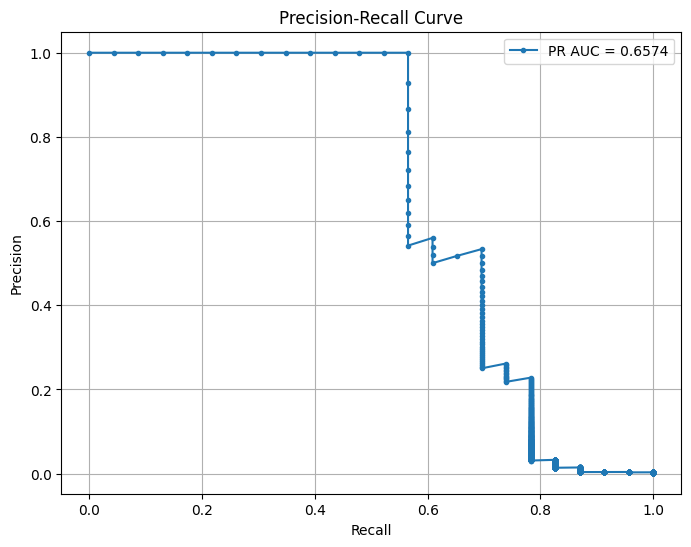

In [36]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc

def preprocess_data(dataset):
    features = []
    labels = []
    
    for i in range(len(dataset)):
        batch_data = dataset[i]
        window_labels = dataset.window_label[i]
        features.append(batch_data.numpy())
        labels.append(window_labels)
        
    X = np.array(features)
    y = np.array(labels)
    
    return X, y

X, y = preprocess_data(dataset)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier(iterations=500, depth=3)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]


best_threshold = 0
best_f1 = 0
thresholds = np.arange(0.0, 1.01, 0.01)

for threshold in thresholds:
    y_pred = (y_pred_proba > threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

y_pred_optimal = (y_pred_proba > best_threshold).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_proba)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

print(f"F1-score: {best_f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


# **Model**

In [8]:
from transformers import BertConfig


class TabFormerBertConfig(BertConfig):
    def __init__(
        self,
        flatten=True,
        ncols=12,
        vocab_size=30522,
        field_hidden_size=64,
        hidden_size=378,
        num_attention_heads=6,
        pad_token_id=0,
        **kwargs
    ):
        super().__init__(pad_token_id=pad_token_id, **kwargs)

        self.ncols = ncols
        self.field_hidden_size = field_hidden_size
        self.hidden_size = hidden_size
        self.flatten = flatten
        self.vocab_size = vocab_size
        self.num_attention_heads=num_attention_heads

In [9]:


from transformers.modeling_utils import PreTrainedModel
from transformers import (
    BertTokenizer,
    BertForMaskedLM,
)


class ddict(object):
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

class TabFormerBertLM:
    def __init__(self, special_tokens, vocab, field_ce=False, flatten=True, ncols=None, field_hidden_size=768):
        self.ncols = ncols
        self.vocab = vocab
        vocab_file = "vocab_big_data"
        hidden_size = field_hidden_size if flatten else (field_hidden_size * self.ncols)

        self.config = TabFormerBertConfig(vocab_size=len(self.vocab),
                                          ncols=self.ncols,
                                          hidden_size=hidden_size,
                                          field_hidden_size=field_hidden_size,
                                          flatten=flatten,
                                          num_attention_heads=self.ncols)

        self.tokenizer = BertTokenizer(vocab_file,
                                       do_lower_case=False,
                                       **special_tokens)
        self.model = self.get_model(field_ce, flatten)

    def get_model(self, field_ce, flatten):
        if flatten and not field_ce:
            # flattened vanilla BERT
            model = BertForMaskedLM(self.config)
        return model

In [15]:
!wandb login 5ff0f835268a508460f994cd971c937a4a6b930e

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [16]:
import wandb

# Initialize W&B
wandb.init(
    project="transaction-fraud-detection",
    name="bert-tabular-model-20",
    config={
        "epochs": 100,
        "batch_size": 32,
        "learning_rate": 5e-5,
    }
)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: stepashkina-vita. Use `wandb login --relogin` to force relogin


In [17]:
from transformers import logging
logging.set_verbosity_info()

In [18]:
from transformers import TrainerCallback, TrainerState, TrainerControl
from tqdm.notebook import tqdm

class CustomProgressBar(TrainerCallback):
    def __init__(self):
        self.pbar = None

    def on_train_begin(self, args, state, control, **kwargs):
        self.pbar = tqdm(total=state.max_steps, desc="Training")

    def on_step_end(self, args, state, control, **kwargs):
        self.pbar.update(1)

    def on_train_end(self, args, state, control, **kwargs):
        self.pbar.close()

In [19]:
# Metric computation
def compute_metrics(pred):
    logits, labels = pred.predictions, pred.label_ids
    probabilities = torch.softmax(torch.tensor(logits), dim=-1).numpy() 
    predictions = np.argmax(probabilities, axis=-1)
    
    if len(predictions.shape) > 1:
        predictions = predictions.flatten()
    if len(labels.shape) > 1:
        labels = labels.flatten()

    if logits.shape[1] > 1:
        y_pred_proba = probabilities[:, 1]
    else:
        y_pred_proba = probabilities.flatten()

    print(f"Logits shape: {logits.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"probabilities shape: {probabilities.shape}")
    print(f"y_pred_proba shape: {y_pred_proba.shape}")

    roc_auc = roc_auc_score(labels, logits[:, 1]) if logits.shape[1] > 1 else 0.0

    best_threshold = 0.0
    best_f1 = 0.0
    thresholds = np.arange(0.1, 0.41, 0.0001)

    for threshold in thresholds:
        y_pred = (y_pred_proba > threshold).astype(int)
        f1 = f1_score(labels, y_pred)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    y_pred_optimal = (y_pred_proba > best_threshold).astype(int)


    precision, recall, _ = precision_recall_curve(labels, y_pred_proba)
    pr_auc = auc(recall, precision)

    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"F1-score: {best_f1:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()

    return {
        "roc_auc": roc_auc,
        "f1_score": best_f1,
        "best_threshold": best_threshold,
        "pr_auc": pr_auc
    }

# **Classification part**

In [20]:
from typing import Dict, List, Union
import torch
from torch.nn.utils.rnn import pad_sequence
from transformers import DataCollatorWithPadding

class ClassificationDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(
        self, examples: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [torch.tensor(example["input_ids"], dtype=torch.long) for example in examples]
        labels = [example["label"] for example in examples]
        batch = self._tensorize_batch(input_ids)
        labels = torch.tensor(labels, dtype=torch.long)

        return {"input_ids": batch, "labels": labels}

    def _tensorize_batch(
        self, examples: List[torch.Tensor]
    ) -> torch.Tensor:
        length_of_first = examples[0].size(0)
        are_tensors_same_length = all(x.size(0) == length_of_first for x in examples)
        if are_tensors_same_length:
            return torch.stack(examples, dim=0)
        else:
            return pad_sequence(examples, batch_first=True, padding_value=self.tokenizer.pad_token_id)


In [21]:
import tqdm

In [22]:
dataset = TransactionDataset(nrows=100_000, task_type = "classification")
vocab = dataset.vocab
custom_special_tokens = vocab.get_special_tokens()
trainN = int(0.7 * len(dataset))
valtestN = len(dataset) - trainN
valN = int(valtestN * 0.4)
testN = valtestN - valN
lengths = [trainN, valN, testN]


100%|██████████| 433/433 [00:01<00:00, 400.11it/s]


In [23]:
train_dataset, eval_dataset, test_dataset = random_split_dataset(dataset, lengths)

# **EXP №3:** bert + GRU head


In [24]:
loaded_tab_net = BertForMaskedLM.from_pretrained("/kaggle/input/bert_6_epochs/pytorch/default/1/bert_6_epochs")
loaded_tokenizer = BertTokenizer.from_pretrained("/kaggle/input/bert_6_epochs/pytorch/default/1/bert_6_epochs")
# loaded_tab_net = BertForMaskedLM.from_pretrained("/content/wandb/bert")
# loaded_tokenizer = BertTokenizer.from_pretrained("/content/wandb/bert")

loading configuration file /kaggle/input/bert_6_epochs/pytorch/default/1/bert_6_epochs/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "field_hidden_size": 768,
  "flatten": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "ncols": 12,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.47.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 15780
}

loading weights file /kaggle/input/bert_6_epochs/pytorch/default/1/bert_6_epochs/model.safetensors
BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't

In [25]:
from sklearn.metrics import roc_auc_score, f1_score

In [26]:
import torch
import torch.nn as nn
from transformers import Trainer, TrainingArguments
from sklearn.metrics import roc_auc_score, f1_score
from transformers import DataCollatorWithPadding

class FraudDetectionModelWithGRU(nn.Module):
    def __init__(self, bert_model, hidden_size, gru_hidden_size, num_classes=2):
        super(FraudDetectionModelWithGRU, self).__init__()
        self.bert = bert_model

        self.gru = nn.GRU(
            input_size=hidden_size,
            hidden_size=gru_hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.classifier = nn.Linear(gru_hidden_size * 2, num_classes)

        for param in self.bert.bert.parameters():
            param.requires_grad = False

        for param in self.bert.bert.encoder.layer[-1].parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert.bert(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        last_hidden_state = hidden_states[-1]  # last layer (batch_size, seq_len, hidden_size)

        gru_output, _ = self.gru(last_hidden_state)  # gru_output: (batch_size, seq_len, gru_hidden_size * 2)

        # Using [CLS] token
        cls_representation = gru_output[:, 0, :]  # (batch_size, gru_hidden_size * 2)

        # classifier
        logits = self.classifier(cls_representation)

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return loss, logits
        return logits

# Data collator
data_collator = ClassificationDataCollator(tokenizer=loaded_tokenizer)

# Training and evaluation arguments
training_args = TrainingArguments(
    output_dir="fraud_detection_results",
    evaluation_strategy="no",
    learning_rate=1e-4,
    per_device_train_batch_size=128,
    num_train_epochs=10,
    weight_decay=0.1,
    # logging_dir="/kaggle/working/",
    logging_dir="/content/",
    save_total_limit=2,
    save_steps=3_500,
    logging_steps=200,
    overwrite_output_dir=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_roc_auc",
    save_strategy = 'no',
    disable_tqdm=False,
    report_to="wandb",
)

# Model setup
num_classes = 2  # Fraud (1) or Not Fraud (0)
hidden_size = loaded_tab_net.config.hidden_size
gru_hidden_size = 618
fraud_model = FraudDetectionModelWithGRU(loaded_tab_net, hidden_size, gru_hidden_size, num_classes)

# Trainer setup
trainer = Trainer(
    model=fraud_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=loaded_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
<ipython-input-26-2baf76f532b9>:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
***** Running training *****
  Num examples = 21,305
  Num Epochs = 10
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 1,670
  Number of trainable parameters = 12,844,958
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different r

Step,Training Loss
200,0.013000
400,0.004900
600,0.003600
800,0.004300
1000,0.003000
1200,0.002100
1400,0.001000
1600,0.000800




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1670, training_loss=0.003940636401404878, metrics={'train_runtime': 492.5514, 'train_samples_per_second': 432.544, 'train_steps_per_second': 3.391, 'total_flos': 0.0, 'train_loss': 0.003940636401404878, 'epoch': 10.0})


***** Running Evaluation *****
  Num examples = 6000
  Batch size = 16
<ipython-input-15-5d10c8103626>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(example["input_ids"], dtype=torch.long) for example in examples]


Logits shape: (6000, 2)
Labels shape: (6000,)
probabilities shape: (6000, 2)
y_pred_proba shape: (6000,)
ROC AUC: 0.9637
F1-score: 0.8571
PR AUC: 0.8263


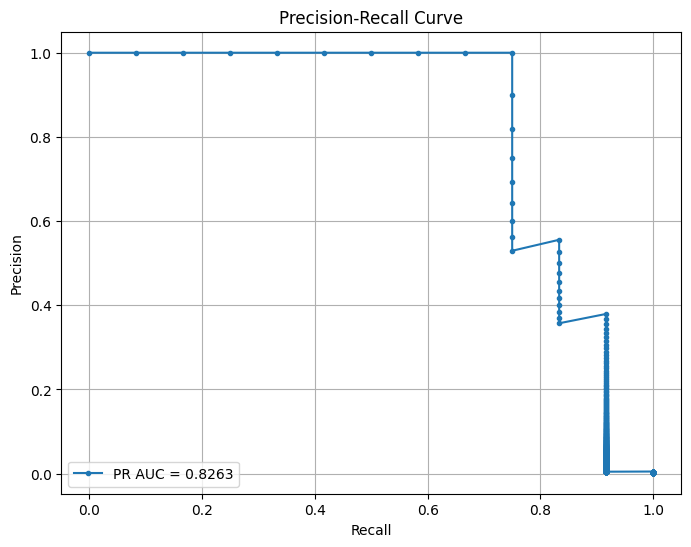

Test ROC AUC: 0.963733021598753


In [76]:
test_results = trainer.evaluate(test_dataset)
print(f"Test ROC AUC: {test_results['eval_roc_auc']}")